In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json
import Levenshtein
from unidecode import unidecode
import unicodedata

In [2]:
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [5]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		elif desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

In [6]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [7]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [31]:
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
_my_stop_words = {"'s", 'news'}
def is_good_word(w):
	return any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words and w not in _my_stop_words

In [9]:
df = pd.DataFrame(
	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in articles]) for i, inst in
	 enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/4719199 [00:00<?, ?it/s]

7419089

In [10]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: 'A new rise in the price of the dollar - Eve News'
Arabic Title: 'ارتفاع جديد في سعر الدولار - Eve News'
Categories: <business>  ---   'United Arab Emirates' (11 Oct20)  ---  Evecorplogo.net
English Description: A new rise in the price of the dollar 'A new rise in the price of the dollar'


In [11]:
bagowords = {int(ID): bag for ID, bag in load_json(root/'bagowords.json').items()}
# for art in tqdm(articles):
# 	if art['ID'] not in bagowords:
# 		bagowords[art['ID']] = Counter([token.lemma_ for token in nlp(unidecode(art.get('en-title', art['title'])))])
# save_json(bagowords, root/'bagowords.json');
lowords = {ID: {k.lower(): v for k,v in bag.items()} for ID, bag in tqdm(bagowords.items())}
all_bags = lowords
len(bagowords)

  0%|          | 0/4719199 [00:00<?, ?it/s]

4719199

In [14]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
# query = 'myanmar burma coup burmese military ahn sang suu kyi aung san aun'
query = 'ahn sang suu kyi aung san aun myanmar burma burmese'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)
print(qkeys)

{'aung', 'san', 'myanmar', 'burmese', 'kyi', 'aun', 'burma', 'ahn', 'suu', 'sing'}


In [15]:
min_hits = 3
matches = Counter()
for ID, bag in tqdm(all_bags.items()):
	hits = qkeys.intersection([k.lower() for k in bag.keys()])
	if len(hits) and (min_hits is None or len(hits) >= min_hits):
		matches[ID] = len(hits)
# matches = Counter([art['ID'] for art in tqdm(articles) if 'suu kyi' in unidecode(art.get('en-title', art['title']).lower())])
# len(matches)
len(matches)

  0%|          | 0/4719199 [00:00<?, ?it/s]

160

In [16]:
sub = df[df['aid'].isin(matches)]
sub

,aid,title,source,language,collectedAt,location,category,iid,date
6558877,547450,Suu Kyi points out that Myanmar faces 'COVID d...,Dailynews.co.th,th,2020-09-03 06:55:00+00:00,th,general,0547450-000,2020-09-03
426674,1743778,Aung San Suu Kyi: Myanmar democracy icon who f...,Yahoo Entertainment,en,2020-11-06 13:38:00+00:00,sa,general,1743778-000,2020-11-06
426675,1743778,Aung San Suu Kyi: Myanmar democracy icon who f...,Yahoo Entertainment,en,2020-11-06 13:38:00+00:00,us,general,1743778-001,2020-11-06
3353365,1757195,"Despite accusations of genocide, Aung San Suu ...",CNN,en,2020-11-07 11:01:00+00:00,us,general,1757195-000,2020-11-07
426806,1758980,A look at Myanmar's election and Suu Kyi's exp...,Associated Press,en,2020-11-07 11:01:00+00:00,sa,general,1758980-000,2020-11-07
...,...,...,...,...,...,...,...,...,...
2711812,5245848,Myanmar protesters wear flowers to mark Suu Ky...,GMA News,en,2021-06-19 08:29:00+00:00,ph,general,5245848-000,2021-06-19
4726609,5260902,Myanmar protesters wear flowers to mark Suu Ky...,The Sun Daily,en,2021-06-20 11:34:00+00:00,my,general,5260902-000,2021-06-20
4449057,5426173,Myanmar's Aung San Suu Kyi urges people to be ...,CNA,en,2021-06-29 09:06:00+00:00,sg,general,5426173-000,2021-06-29
2728744,6494786,Myanmar junta to put Suu Kyi on trial for corr...,GMA News,en,2021-09-17 11:47:00+00:00,ph,general,6494786-000,2021-09-17


In [17]:
cat = 'language'
grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')

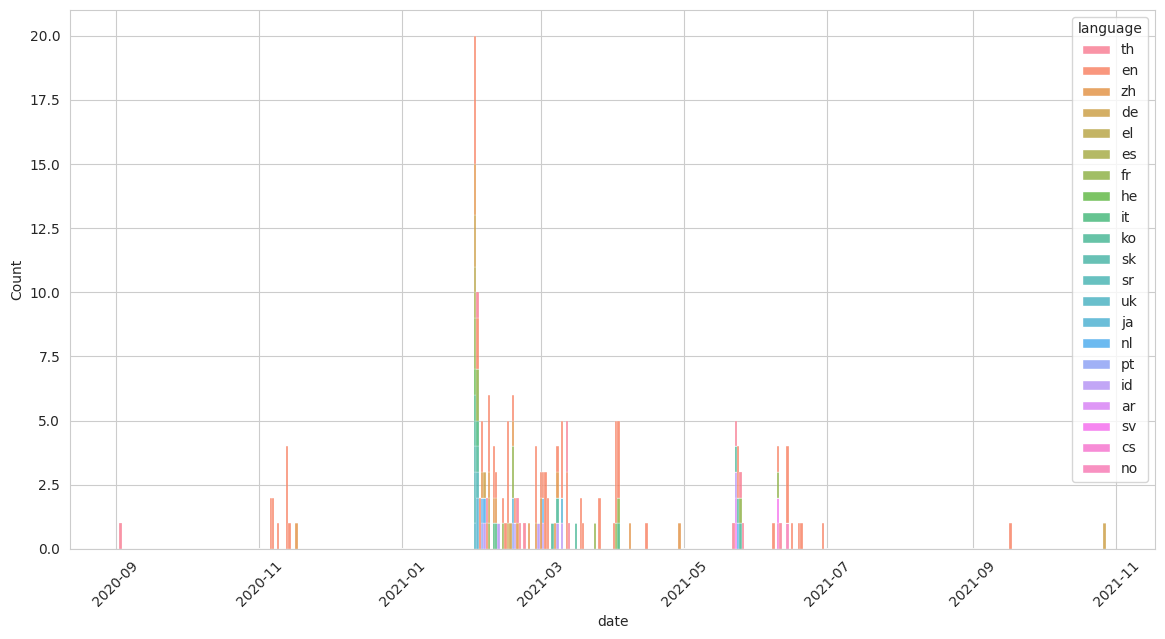

In [18]:
plt.figure(figsize=(14, 7))
sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45);

In [44]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(set))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags)

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [45]:
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f)  for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [251]:
target = datetime(2021, 2, 1).date()
# target = datetime(2021, 1, 7).date()
today_aids = date_aids[target]
today_bag = daybags[target]
today_df = df[df['date'] == target]
today_tfidf = daytfidf[target]
importances = today_tfidf
len(today_bag), len(today_aids), sum(len(all_bags[aID]) for aID in today_aids) / len(today_aids)

(13674, 5475, 16.162374429223743)

In [252]:
# today_idf = Counter()
# for aID in tqdm(today_aids):
# 	today_idf.update(all_bags[aID].keys())
# today_idf = {w: np.log(len(today_aids) / f)  for w, f in today_idf.items()}
# today_tf = 
# today_totals = sum(today_bag.values())
# today_tfidf = Counter({w: f / today_totals * today_idf[w] for w, f in today_bag.items() if is_good_word(w)})
print(tabulate(today_tfidf.most_common(10)))

--------  -----------
suu       0.000369643
kyi       0.000356896
gamestop  0.000330922
aung      0.000327231
1/31/21   0.000313604
wilmore   0.000297209
caleta    0.000184187
reddit    0.000180564
2/1/21    0.000166509
sowon     0.000164272
--------  -----------


In [253]:
treat_bags_as_sets = True
prior_art_scores = Counter({aID: sum(importances[w] * (1 if treat_bags_as_sets else f) for w, f in all_bags[aID].items() if w in importances) for aID in tqdm(today_aids)})
def article_affinity(aid1, aid2):
	bag1, bag2 = all_bags[aid1], all_bags[aid2]
	return sum(importances[w] * (1 if treat_bags_as_sets else min(f, bag2[w])) for w, f in bag1.items() if w in bag2) / np.sqrt(prior_art_scores[aid1] * prior_art_scores[aid2])

  0%|          | 0/5475 [00:00<?, ?it/s]

In [254]:
links = Counter({(aid1, aid2): article_affinity(aid1, aid2) for aid1 in tqdm(today_aids) for aid2 in today_aids if aid1 < aid2})
links = Counter({(aid1, aid2): f for (aid1, aid2), f in links.items() if f > 0.})
len(links)

  0%|          | 0/5475 [00:00<?, ?it/s]

/tmp/ipykernel_1128367/2047888240.py:5: RuntimeWarning: invalid value encountered in scalar divide
  return sum(importances[w] * (1 if treat_bags_as_sets else min(f, bag2[w])) for w, f in bag1.items() if w in bag2) / np.sqrt(prior_art_scores[aid1] * prior_art_scores[aid2])


148662

In [255]:
# print(tabulate(links.most_common(10)))

In [256]:
G = nx.Graph()
G.add_edges_from((aid1, aid2, {'weight': f}) for (aid1, aid2), f in links.items() if f > 1e-8)
len(G), len(G.edges)

(5447, 148662)

In [257]:
print(tabulate([(i, imp, by_ID[aid]['language'], by_ID[aid]['ID'], by_ID[aid].get('en-title', by_ID[aid]['title'])) for i, (aid, imp) in enumerate(prior_art_scores.most_common(100))]))

--  -----------  --  -------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 0  0.00132559   es  2906997  Coup d'état in Myanmar: the army takes power "for a year" and detains Aung San Suu Kyi - Clarín.com
 1  0.00127793   zh  2909178  [Aung San Suu Kyi was arrested] The Myanmar military said there would be another election in a year. Aung San Suu Ya called on the people to resist the coup - Hong Kong Economic Daily - Real-time News Channel - International Situation - Global Social Hotspots - Hong Kong Economic Daily - Real-Time News
 2  0.00126899   zh  2910547  Aung San Suu Kyi and many others were detained by the military. What is the current situation in Yangon, Myanmar? _Headquarters-Sohu
 3  0.00124694   sk  2908388  Putsch in

In [258]:
c = random.choice(list(today_aids))
# c = 2906997
# c = 2909198
# c = 2911138
# c = 2906738

neighbors = Counter({(v if u == c else u): w for u,v,w in G.edges(c, data='weight')})
narts = {aid:by_ID[aid] for aid in neighbors}
len(neighbors)

6

In [259]:
# print(tabulate(neighbors.most_common(10)))
view_article(by_ID[c])
print(tabulate([(i, aff, narts[aid]['language'], narts[aid]['instances'][0]['collectedAt'].split('T')[0], narts[aid].get('en-title', narts[aid]['title'])) for i, (aid, aff) in enumerate(neighbors.most_common(100))]))

English Title: 'Is planning for 2021 possible?: how to reorganize life in the face of uncertainty - Diario El Día'
Spanish Title: '¿Planificar el 2021 es posible?: cómo reorganizar la vida ante la incertidumbre - Diario El Día'
Categories: <science>  ---   'Argentina' (01 Feb21)  ---  Diario El Dia. www.eldia.com
-  ---------  --  ----------  ------------------------------------------------------------------------------------------------------------
0  0.0705122  es  2021-02-01  Prepaid medicine goes up: how much will the increase be - El Diario Nuevo Dia
1  0.0668101  he  2021-02-01  Uncertainty in Maccabi Tel Aviv: "They don't know what game to prepare for now" - ynet.co.il
2  0.0534963  es  2021-02-01  AMLO's mishandling of COVID information caused unnecessary uncertainty, they say - SinEmbargo
3  0.0435313  pt  2021-02-01  Petrópolis has 153 people hospitalized with COVID-19 - Jornal O Dia
4  0.0284235  pt  2021-02-01  Grupo DIA closes Clarel stores in Portugal until the end of Mar

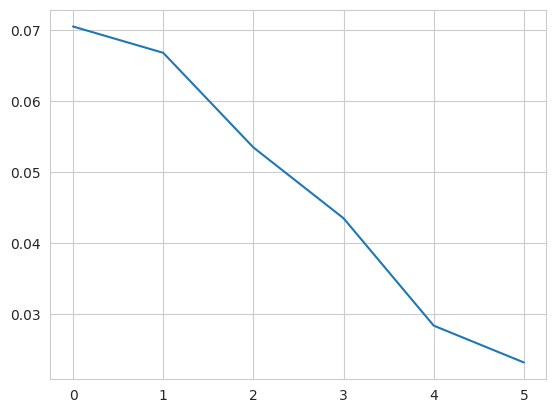

In [260]:
plt.plot(sorted(neighbors.values(), reverse=True))

In [261]:
art_imps = list(prior_art_scores.most_common())
len(art_imps)

5475

In [262]:
xs = np.array([c for c, _ in art_imps[:400]])
rawsims = [sorted([w for u,v,w in G.edges(c, data='weight')], reverse=True) for c in xs]
longest = max(len(s) for s in rawsims)
sims = np.zeros((len(rawsims), longest))
for i, s in enumerate(rawsims):
	sims[i, :len(s)] = s
sims.shape

(400, 248)

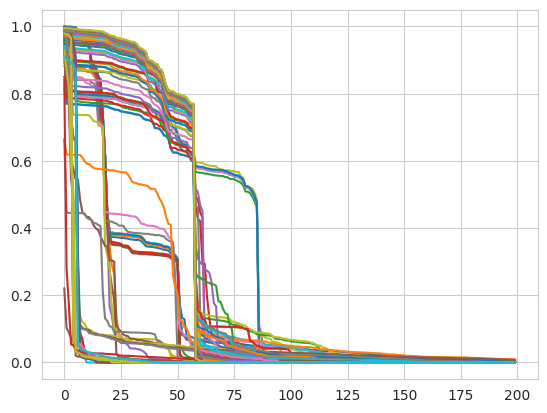

In [263]:
plt.plot(sims[:100,:200].T);

In [264]:
from sklearn.cluster import DBSCAN

In [271]:
cus = DBSCAN(eps=0.02, min_samples=2, metric='cosine')
cus.fit(sims);

In [272]:
lbls = cus.labels_
counts = Counter(lbls)
print(counts)

Counter({5: 66, 7: 65, 8: 59, 2: 53, 4: 41, 1: 35, 6: 22, 0: 15, -1: 10, 12: 10, 10: 9, 3: 6, 11: 4, 9: 3, 13: 2})


In [273]:
art_clusters = {cidx: xs[lbls==cidx].tolist() for cidx in set(lbls) if cidx >= 0}
tbl = []
for cidx, aids in art_clusters.items():
	
	arts = [by_ID[aid] for aid in aids]
	
	langs = Counter([art['language'] for art in arts])
	cats = Counter([i['category'] for art in arts for i in art['instances']])
	locs = Counter([i['location'] for art in arts for i in art['instances']])
	
	imp = sum(prior_art_scores[aid] for aid in aids)
	
	toptok = Counter()
	for art in arts:
		for w in all_bags[art['ID']]:
			toptok[w] += importances[w]
	
	tbl.append([
		cidx,
		len(aids),
		imp,
		', '.join(f'{token!r}' for token, f in toptok.most_common(10)),
		', '.join(f'{lang}:{f}' for lang, f in langs.most_common()),
		', '.join(f'{cat[:3]}:{f}' for cat, f in cats.most_common()),
		# ', '.join(f'{loc_names[loc]}:{f}' for loc, f in locs.most_common()),
	])
print(tabulate(sorted(tbl, key=lambda row: row[2], reverse=True)))

--  --  -----------  ------------------------------------------------------------------------------------------------------------------------------------  -----------------------------------------------------------------------------------------------------------------------------------  ----------------------------------------------------
 2  53  0.020257     'gamestop', 'wallstreetbet', 'melvin', 'robinhood', 'verbio', 'hotstockreport', 'redditor', 'ehang', 'chevron', 'sollner'             en:13, es:8, de:7, zh:3, sv:3, pl:2, pt:2, fr:2, he:2, tr:1, no:1, nl:1, th:1, it:1, ru:1, uk:1, lt:1, hu:1, ar:1, el:1              bus:56, gen:12, tec:10, ent:1
 0  15  0.0180778    'suu', 'kyi', 'aung', 'myanmar', 'coup', "d'etat", 'yangon', 'putsch', 'san', 'clarin.com'                                            en:4, zh:2, sr:2, es:1, sk:1, ko:1, uk:1, de:1, el:1, he:1                                                                           gen:16
 7  65  0.0123416    '1/31/21', 'sowon', 'ga10

59
-  -----------  --  ----------  --------------------------------------------------------------------------------------------------------------------------
0  0.000186863  tr  2021-02-01  Silver reached its highest level in the last 8 years after mass purchases by Reddit users - BBC Turkish
1  0.000188651  lv  2021-02-01  The coup in Myanmar is condemned by both the USA and the EU / Article - Lsm.lv
2  0.000210006  ko  2021-02-01  'All passenger flights to Myanmar are suspended... Yangon International Airport closed until May' - Seoul Economic Daily
3  0.000195251  en  2021-02-01  Myanmar's military reverts to its old strong-arm behaviour — and the country takes a major step backwards - Stuff.co.nz
4  0.000161614  ja  2021-02-01  Banks are shut down, rice is in short supply, cellphones cannot be used... Myanmar in chaos - Livedoor News - livedoor
5  0.000190079  sl  2021-02-01  The price of silver jumped, and the 'culprits' are Reddit users - 24ur.com
6  0.000204219  en  2021-02-01  

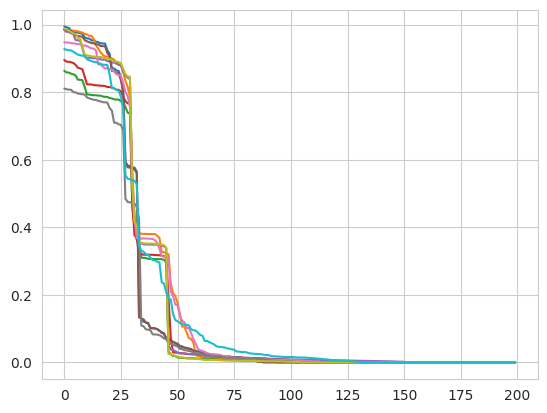

In [276]:
cidx = 8
sel = np.arange(len(lbls))[lbls==cidx]
sel = np.random.choice(sel, min(10, len(sel)), replace=False)
print(counts[cidx])
plt.plot(sims[sel,:200].T);

seq = xs[sel]
print(tabulate([(i, prior_art_scores[aid], by_ID[aid]['language'], by_ID[aid]['instances'][0]['collectedAt'].split('T')[0], by_ID[aid].get('en-title', by_ID[aid]['title'])) for i, aid in enumerate(seq)]))

In [241]:
importances

Counter({'capitol': 0.0004513574060341311,
         '146,000': 0.00025588169283725617,
         'neighborwebsj': 0.00021912689065271346,
         'dre': 0.00017480194320213685,
         'ces': 0.00017350129815722323,
         'dakar': 0.0001707959061848188,
         '7/01/21': 0.0001398090628592269,
         '20210107': 0.00012917407188295244,
         'fultz': 0.00012903228482054907,
         'jan.': 0.00011639818586505462,
         '1/6/21': 0.00011284978572613493,
         'tanya': 0.00010669842123668431,
         'nyse': 0.00010505026823959952,
         '1.1.9.0': 9.98636163280192e-05,
         '10i': 9.910118856544673e-05,
         'wilde': 9.805135010065035e-05,
         'food.noteru.com': 9.75949306605949e-05,
         'bischofshofen': 9.28127975682284e-05,
         'atkinson': 8.9326275436246e-05,
         'aneurysm': 8.917791863630344e-05,
         'rowan': 8.870953654122114e-05,
         'mfm': 8.625408972400135e-05,
         'epiphany': 8.625408972400135e-05,
         '20210

In [15]:
today_sets = {aid: set(all_bags[aid].keys()) for aid in today_aids}

aious = {(aid, aid2): len(set(bagsets[aid]).intersection(set(bagsets[aid2]))) / len(set(bagsets[aid]).union(set(bagsets[aid2]))) for aid in tqdm(date_aids[target]) for aid2 in date_aids[target] if aid < aid2}
len(aious)

  0%|          | 0/6928 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
deltas = {}
dates = list(daybags.keys())
valid_dates = []
for d1, d2 in tqdm(zip(dates[:-1], dates[1:]),total=len(dates)-1):
	if (d2 - d1).days == 1:
		valid_dates.append(d2)
		deltas[d2] = daybags[d2] - daybags[d1]
global_bag = Counter()
for date in valid_dates:
	global_bag.update(daybags[date])
len(deltas), len(global_bag)

  0%|          | 0/412 [00:00<?, ?it/s]

(371, 371, 477258)

In [56]:
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f)  for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [57]:
target = datetime(2021, 2, 1).date()
# df[df['date'] == target]
len(daybags[target])

13674

In [61]:
print(tabulate(daytfidf[target].most_common(30)))

--------------  -----------
3885            0.000442286
1/31/21         0.000399841
-iss            0.000399841
gamestop        0.00035309
suu             0.000309284
ugc             0.000308742
crafoord        0.00029988
nightscout      0.00029988
kyi             0.000299367
wombat          0.000296615
wilmore         0.00027067
2/1/21          0.000265372
aung            0.00026076
tonbridge       0.0002499
nauru           0.000246993
635             0.000222965
kawaii          0.000222461
fibroblast      0.000219754
manhood         0.000217766
battleborn      0.000210677
micronutrients  0.000204321
calculations    0.000200977
letsupload      0.00019992
distractible    0.00019992
reddit          0.000194669
wallstreetbet   0.000193713
plitidepsin     0.000192386
solving         0.000184313
meganium        0.000176914
caleta          0.00016774
--------------  -----------


In [59]:
dt = deltas[target]
len(dt)

9073

In [25]:
keywords = Counter({w:f for w, f in dt.items() if any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words})
len(keywords)

9005

In [44]:
wts = Counter({w: f / global_bag[w] for w, f in daybags[target].items()})
len(wts)

13674

In [63]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [91]:
# corrs = {}
# for w , _ in tqdm(keywords.most_common()):
# 	for aid in date_aids[target]:
# 		bag = all_bags[aid]
# 		if w in bag:
# 			corrs.setdefault(w, Counter()).update(bag.keys())
# len(corrs)

present = {}
for aid in date_aids[target]:
	bag = all_bags[aid]
	for w in bag:
		if w in keywords:
			present.setdefault(w, set()).add(aid)
len(present)
ious = {w: Counter({w2: len(present[w].intersection(present[w2])) / len(present[w].union(present[w2])) for w2 in present if w != w2}) for w in tqdm(present)}
len(ious)

  0%|          | 0/9005 [00:00<?, ?it/s]

9005

In [109]:
importances = daytfidf[target]
scores = {w: Counter({w2: ious[w][w2] * np.sqrt(importances[w2] * importances[w]) for w2 in ious[w]}) for w in tqdm(ious)}

  0%|          | 0/9005 [00:00<?, ?it/s]

In [28]:
token = 'news'
print(tabulate([(w, s) for w, s in scores[token].most_common(30) if w != token]))

NameError: name 'scores' is not defined

In [140]:
G = nx.Graph()
for w, iou in tqdm(scores.items()):
	G.add_edges_from((w, w2, {'weight': f}) for w2, f in iou.items() if w > w2 and f > 9e-7)
len(G), len(G.edges)

  0%|          | 0/9005 [00:00<?, ?it/s]

(7365, 11623)

In [125]:
import community as community_louvain

In [126]:

# Compute the best partition using the Louvain algorithm
partition = community_louvain.best_partition(G)


In [127]:

# partition is a dictionary where the key is the node and the value is the cluster id
# for node, cluster_id in partition.items():
#     print(f'Node {node} is in cluster {cluster_id}')

# Optionally, you can also assess the quality of the partition
modularity = community_louvain.modularity(partition, G)
print(f"The modularity of the partition is {modularity}")

The modularity of the partition is 0.7202137514474273


In [135]:
clusters = {}
for node, cluster_id in partition.items():
	clusters.setdefault(cluster_id, []).append(node)
print([len(clid) for clid in clusters.values()])
len(clusters)

[1104, 127, 190, 1406, 433, 161, 213, 412, 226, 105, 74, 217, 263, 83, 78, 99, 63, 61, 45, 9, 42, 4, 26, 6]


24

In [138]:
clsid = partition[2906997]
clsid = 0
print(clsid, len(clusters[clsid]))
print(sorted(clusters[clsid], key=lambda aid: importances[aid], reverse=True))

0 1104
[2392207, 2905434, 2906164, 2906619, 2907832, 2909551, 2906262, 2907259, 2909715, 2910026, 2899241, 2900254, 2904967, 2905100, 2905488, 2905803, 2906433, 2906797, 2907548, 2908147, 2908295, 2904960, 2908778, 2910546, 2910804, 2910972, 2911033, 2906238, 2906523, 2908053, 2908110, 2908503, 2909427, 2911347, 1181063, 2369011, 2905166, 2905493, 2908336, 2908448, 2909109, 2911644, 2911797, 2911798, 2911860, 198353, 236513, 339466, 2568024, 571569, 571872, 2898471, 2905242, 2905972, 2906237, 2906801, 2906814, 2907010, 2907177, 2907298, 2907309, 2121444, 2907914, 2908773, 2908899, 2908958, 2910767, 2910904, 2911211, 916158, 2906055, 2906057, 2906124, 2906715, 2908724, 2911299, 2911349, 2899926, 2904930, 2905370, 2314, 2787772, 2900, 3509, 2899827, 151362, 2085300, 2905113, 2905848, 2906093, 2906310, 2906698, 2906760, 2906954, 2907256, 2907801, 2907925, 2908203, 2908414, 2908841, 2908892, 2908919, 2908984, 2908994, 2909025, 2909074, 2909547, 26090, 2909829, 2910438, 2910915, 2910969, 29

In [139]:
print(tabulate([(aid, by_ID[aid]['language'], by_ID[aid]['instances'][0]['collectedAt'].split('T')[0], by_ID[aid].get('en-title', by_ID[aid]['title'])) 
				for aid in sorted(clusters[clsid], key=lambda aid: importances[aid], reverse=True)]))

-------  --  ----------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2392207  th  2020-12-28  Nation TV, Thailand's number 1 news station website | Economy - Nation TV, 24-hour news station
2905434  uk  2021-02-01  The expert told which websites should never be visited in public places - GSMinfo
2906164  ar  2021-02-01  A doctor warns against heating living things on a stove: it causes cancer - Colors of the Nation - Alwan
2906619  pt  2021-02-01  Website publishes alleged audios of Maradona's doctor: 'He's going to die shitting' - UOL Esporte
2907832  en  2021-02-01  The road from Meath to the 2021 Six Nations via Brisbane and Belfast - The42
2909551  ar  2021-02-01  Houria Farghali undergoes a delicate surgery that took 9 hours - Al Jadeed Official Website
2906262  en  2021-02-01  Pregnant S

In [440]:
# w, f = keywords.most_common()[0]
# w, f, any(not unicodedata.category(char).startswith('P') for char in w), w not in stop_words

In [26]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [27]:
keywords['aung']

19

In [92]:
token = 'kyi'
included = [ID for ID, bag in all_bags.items() if token in bag]
len(included)

170

In [93]:
# matching instances
df[df['aid'].isin(included)][df['date'] == target]

/tmp/ipykernel_1128367/2288863398.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['aid'].isin(included)][df['date'] == target]


,aid,title,source,language,collectedAt,location,category,iid,date
5299712,2906997,"Coup d'état in Myanmar: the army takes power ""...",Clarín,es,2021-02-01 14:11:00+00:00,ar,general,2906997-000,2021-02-01
5020331,2910418,Military coup in Burma and Suu Kyi: answers an...,Www.nzz.ch,de,2021-02-01 14:11:00+00:00,ch,general,2910418-000,2021-02-01
168220,2910066,Aung San Suu Kyi: The Myanmar Lady Who Became ...,News247.gr,el,2021-02-01 14:11:00+00:00,gr,general,2910066-000,2021-02-01
527302,2910866,"Burma, coup d'état: Aung San Suu Kyi arrested....",Ilfattoquotidiano.it,it,2021-02-01 14:11:00+00:00,it,general,2910866-000,2021-02-01
6164961,2906440,"Army on the streets of Myanmar, Aung San Suu K...",Www.rts.rs,sr,2021-02-01 14:11:00+00:00,rs,general,2906440-000,2021-02-01
6164972,2907976,"The army staged a coup in Myanmar, Prime Minis...",Danas.rs,sr,2021-02-01 14:11:00+00:00,rs,general,2907976-000,2021-02-01
2555915,2909178,[Aung San Suu Kyi was arrested] The Myanmar mi...,Hket.com,zh,2021-02-01 14:11:00+00:00,hk,general,2909178-000,2021-02-01
4315455,2907695,"Aung San Suu Kyi, Myanmar leader, detained in ...",Thecable.ng,en,2021-02-01 14:11:00+00:00,ng,general,2907695-000,2021-02-01
7240316,2910547,Aung San Suu Kyi and many others were detained...,Sohu.com,zh,2021-02-01 14:11:00+00:00,cn,general,2910547-000,2021-02-01
3811936,2910175,Coup in Myanmar: Aung San Suu Kyi calls for pr...,Süddeutsche Zeitung,de,2021-02-01 14:11:00+00:00,de,general,2910175-000,2021-02-01
